[En français](../use-case-oafeat-fr/)  

![ECCC logo](https://eccc-msc.github.io/open-data/img_eccc-logo.png)  

[TOC](https://eccc-msc.github.io/open-data/readme_en/) > [Usage overview](https://eccc-msc.github.io/open-data/usage/readme_en/) > OGC API - Features request in Python

# Use case: Tracking water level with GeoMet-OGC-API

## Introduction

Hydrometric data from the Meteorological Service of Canada (MSC) and Environment and Climate Change Canada (ECCC) can be easily accessed via [GeoMet-OGC-API](https://geo.weather.gc.ca/geomet/features/?f=html). The [OGC API - Features](https://eccc-msc.github.io/open-data/msc-geomet/web-services_en/#ogc-api-features) web services available in [GeoMet-OGC-API](https://geo.weather.gc.ca/geomet/features/?f=html) offer the capability to query vector geospatial data and retrieve it in a GeoJSON format. The GeoJSON file can than be used for display or further data processing. This use case will show you how you can:
* Query and retrieve vector geospatial data from [GeoMet-OGC-API](https://geo.weather.gc.ca/geomet/features/?f=html) with [Python](https://www.python.org/)
* Display the retrieved data on a web map
* Analyse the data and display the results in graphic and tabular format

An [interactive version of this Jupyter Notebook is available](here)

[![badge](https://img.shields.io/badge/Interactive%20version-binder-F5A252.svg?logo=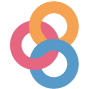)](link)

## Creation of a tool to track water level 

Cathy runs a boat tours and water sports company in Chilliwack, British-Columbia. She would like to track the water level of a few hydrometric stations near her city to guide the management of the company activities. She would like to have:
* An overview of the distribution of the daily water level of the past 3 months for all hydrometric stations located within 100 km of the city of Chilliwack (minimum, first quartile, median, third quartile and maximum) 
* A graphic view that presents the provisional daily mean water level of the past 3 months with a color code to indicate the water level status
* A tabular view that shows the provisional daily mean water level of the past 3 months with the same color code
* A web map that displays the hydrometric stations located within 100 km of the city of Chilliwack and the most recent provisional daily mean water level of these stations with the appropriate color code

To achieve this, the first step is to retrieve the water level data from [GeoMet-OGC-API](https://geo.weather.gc.ca/geomet/features/?f=html) with Python.

In [1]:
# Module importation
from datetime import date
import statistics as stats

from dateutil.relativedelta import relativedelta
from owslib.ogcapi.features import Features
from osgeo import ogr, osr

In [2]:
# Parameters
lat = 49.162676
long = -121.958943
buffer = 100 #km
numMonths = 3

# Prefered projection
# NAD83 / Statistics Canada Lambert
projection = 3347 

In [3]:
# Bbox a little bigger than buffer size (1 km ≈ 0.01°)
bbox = [str(long-(buffer/2)*0.01),
        str(lat-(buffer/2)*0.01),
        str(long+(buffer/2)*0.01),
        str(lat+(buffer/2)*0.01)
       ]

# Time
endDate = date.today()
endDate = date(2013, 8, 13) # Available data to test code
startDate = endDate - relativedelta(months=numMonths)
startDate = startDate.strftime("%Y-%m-%d")
time = f'{startDate}/{endDate}'

In [4]:
oafeat = Features('https://geo.weather.gc.ca/geomet/features')
stationData = oafeat.collection_items('hydrometric-stations', bbox=bbox, STATUS_EN='Active')

In [5]:
# Set the driver
driver = ogr.GetDriverByName('GeoJSON')

# Create a datasource and get the layer
stationData = str(stationData).replace("'", '"').replace("None", "null")
dataSource = driver.Open(stationData, 0) # 0 means read-only. 1 means writeable.
layer = dataSource.GetLayer()

# Identify input spatial reference system
srsInput = layer.GetSpatialRef()
sr = osr.SpatialReference(str(srsInput))
epsg = sr.GetAuthorityCode(None)
srsInput.ImportFromEPSG(int(epsg))

# Spatial reference system used to project data
srsProjected = osr.SpatialReference()
srsProjected.ImportFromEPSG(projection)

# Transformation from input srs to NAD83 / Statistics Canada Lambert
transform = osr.CoordinateTransformation(srsInput, srsProjected)

# Create a buffer to select stations
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(long, lat)
point.Transform(transform)
pointBuffer = point.Buffer(buffer*1000) # The value must be in meters

# Select the stations in the buffer zone
stations = []
for feature in layer:
    geom = feature.GetGeometryRef().Clone()
    geom.Transform(transform)
    if geom.Intersects(pointBuffer):
        stations.append(feature.GetField('STATION_NUMBER'))

In [6]:
len(stations)

18

In [7]:
waterLevel = {}
for station in stations:
    hydroData = oafeat.collection_items(
        'hydrometric-daily-mean',
        bbox=bbox,
        time=time,
        STATION_NUMBER=station
    )
    levelValues = []
    for feature in hydroData['features']:
        levelValues.append(feature['properties']['LEVEL'])
    waterLevel[station] = levelValues

In [8]:
print(stats.mean(waterLevel['08MH147']))
print(stats.median(waterLevel['08MH147']))

3.116451612082861
3.1070001125335693
